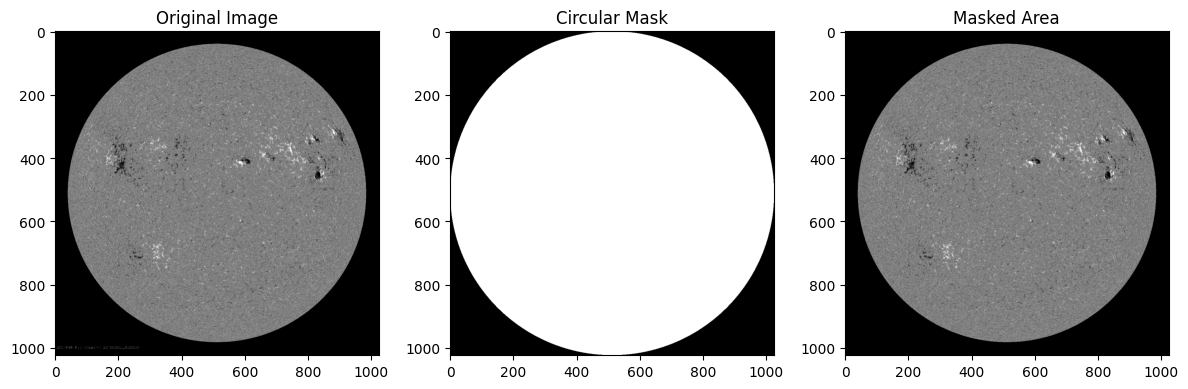

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def apply_fft(patch):
    f = np.fft.fft2(patch)
    f_shift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(f_shift) + 1)
    return magnitude_spectrum

def save_patch(patch, num, dir_name, prefix="patch"):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    path = os.path.join(dir_name, f"{prefix}_{num}.png")
    cv2.imwrite(path, patch)

def create_circular_mask(img_shape, center=None, radius=None):
    h, w = img_shape
    if center is None:
        center = (w // 2, h // 2)
    if radius is None:
        radius = min(center[0], center[1], w - center[0], h - center[1])
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)
    mask = dist_from_center <= radius
    return mask

def display_masked_area(img, mask):

    masked_img = cv2.bitwise_and(img, img, mask=mask.astype(np.uint8))
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(img, cmap="gray")
    
    plt.subplot(1, 3, 2)
    plt.title("Circular Mask")
    plt.imshow(mask, cmap="gray")
    
    plt.subplot(1, 3, 3)
    plt.title("Masked Area")
    plt.imshow(masked_img, cmap="gray")
    
    plt.tight_layout()
    plt.show()

def extract_fft_patches(img, kernel_size=(128, 128), out_dir="fft_patches"):
    h, w = img.shape
    kh, kw = kernel_size
    stride = 128
    mask = create_circular_mask(img.shape)
    display_masked_area(img, mask)

    total_energy = 0
    patch_count = 0
    for y in range(0, h - kh + 1, stride):
        for x in range(0, w - kw + 1, stride):
            if not mask[y:y + kh, x:x + kw].all():
                continue
            patch = img[y:y + kh, x:x + kw]
            magnitude_spectrum = apply_fft(patch)
            low_freq_energy = np.sum(magnitude_spectrum[56:72, 56:72])
            total_energy += low_freq_energy
            patch_count += 1

    avg_energy = total_energy / patch_count if patch_count > 0 else 0


    num = 0
    for y in range(0, h - kh + 1, stride):
        for x in range(0, w - kw + 1, stride):
            if not mask[y:y + kh, x:x + kw].all():
                continue
            patch = img[y:y + kh, x:x + kw]
            magnitude_spectrum = apply_fft(patch)
            low_freq_energy = np.sum(magnitude_spectrum[56:72, 56:72])

            if low_freq_energy > avg_energy:
                save_patch(patch, num, out_dir, prefix="bright_spot")
                num += 1

img_path = '3.jpg'
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (1024, 1024))
extract_fft_patches(img, kernel_size=(128, 128), out_dir="fft_patches")
